# Updating priors

For the coin tossing example, we had the following code to obtain samples from the posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


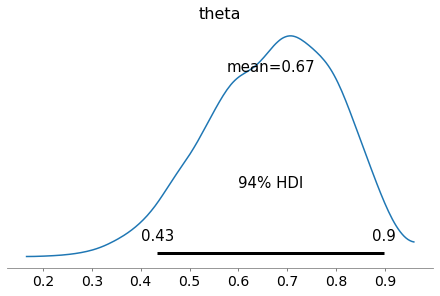

In [2]:
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from scipy import stats
import numpy as np

# Sample data
data = [1, 1, 1, 0, 1, 1, 0, 0, 1, 1]

with pm.Model():
    # The following line defines the prior, theta distributes as Beta(1,1)
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # The following line defines the likelihood Bernoulli with p=theta
    y = pm.Bernoulli('y', p=theta, observed=data)
    # This line generates 1000 samples of the posterior
    trace = pm.sample(1000,  progressbar=True)

    # Plot the sampled posterior
    pp = az.plot_posterior(trace)
    plt.show()

Suppouse that now you have 20 extra sample points of the data. How to include this data on the analysis?

In [3]:
new_data = [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In order to update our beliefs about the parameters, we use the posterior distributions, which will be used as the prior distributions for the next inference. The data used for each inference iteration has to be independent from the previous iterations, otherwise the same (possibly wrong) belief is injected over and over in the system, amplifying the errors and misleading the inference. By ensuring the data is independent, the system should converge to the true parameter values.

Because we draw samples from the posterior distribution, we need to estimate their probability density. Kernel density estimation (KDE) is a way to achieve this, and we will use this technique here. In any case, it is an empirical distribution that cannot be expressed analytically. Fortunately PyMC3 provides a way to use custom distributions, via Interpolated class.

In [4]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    # Note that the domain can not be extended beyond the interval [0,1].
    x = np.concatenate([[0], x, [1]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y)

Why the domain should not be extended bellow the interval [0,1]?

Now we just need modify our Bayesian model so that the prior distributions for the current iteration are the posterior distributions from the previous iteration. It is still possible to continue using NUTS sampling method because Interpolated class implements calculation of gradients that are necessary for Hamiltonian Monte Carlo samplers.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


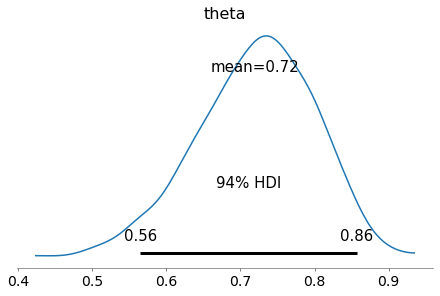

In [25]:
with pm.Model() as updated_model:
    # Priors are posteriors from previous iteration
    theta = from_posterior("theta", trace["theta"])

    # The following line defines the likelihood Bernoulli with p=theta
    y = pm.Bernoulli('y', p=theta, observed=new_data)

    # This line generates 1000 samples of the posterior
    traces_new = pm.sample(1000,  progressbar=True)
    
    # Plot the sampled posterior
    pp = az.plot_posterior(traces_new)
    plt.show()

The following code solves the same problem but using all the data at once

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8874778117145824, but should be close to 0.8. Try to increase the number of tuning steps.


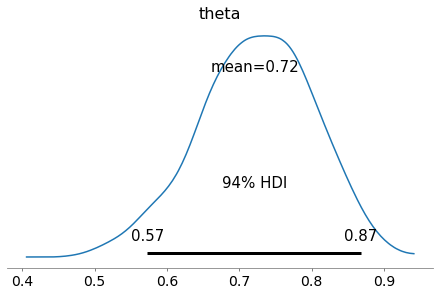

In [56]:
with pm.Model():
    # The following line defines the prior, theta distributes as Beta(1,1)
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # The following line defines the likelihood Bernoulli with p=theta
    y = pm.Bernoulli('y', p=theta, observed=data+new_data)
    # This line generates 1000 samples of the posterior
    trace = pm.sample(1000,  progressbar=True)

    # Plot the sampled posterior
    pp = az.plot_posterior(trace)
    plt.show()

# Posterior predictions and posterior predictivie checks

One of the nice elements of the Bayesian toolkit is that once we have a posterior, it is
possible to use the posterior, $p\left( {\theta \left| y \right.} \right)$, to generate predictions, $\widetilde y$ , based on the data, $y$, and the estimated parameters, $\theta$. The posterior predictive distribution is:

$$
\begin{equation}
p\left( {\widehat y\left| y \right.} \right) = \int {p\left( {\widehat y\left| \theta  \right.} \right)p\left( {\theta \left| y \right.} \right)d\theta }.
\end{equation}
$$


Thus, the posterior predictive distribution is an average of conditional predictions over the
posterior distribution of . Conceptually (and computationally), we approximate this
integral as an iterative two-step process:

* We sample a value of $\theta$ from the posterior ${p\left( {\theta \left| y \right.} \right)}$.
* We feed that value of $\theta$ to the likelihood (or sampling distribution if you wish), thus obtaining a data point $\widetilde y$.

Notice how this process combines two sources of uncertainty: the
parameters uncertainty; as captured by the posterior; and the sampling
uncertainty; as captured by the likelihood.

The generated predictions, $\widetilde y$, can be used when we need to make, predictions. But
also we can use them to criticize the models by comparing the observed data, $y$, and the
predicted data, $\widetilde y$, to spot differences between these two sets, this is known as posterior
predictive checks. The main goal is to check for auto-consistency. The generated data and
the observed data should look more or less similar, otherwise there was some problem
during the modeling or some problem feeding the data to the model. But even in the
absence of mistakes, differences could arise. Trying to understand the mismatch could lead
us to improve models or at least to understand their limitations. Knowing which parts of
our problem/data the model is capturing well and which it is not is valuable information
even if we do not know how to improve the model. Maybe the model captures the mean
behavior of our data well but fails to predict rare values. This could be problematic for us,
or maybe we only care about the mean, so this model will be OK to us. The general aim is
not to declare that a model is false. We just want to know which part of the model we can
trust, and try to test whether the model is a good fit for our specific purpose. How
confident one can be about a model is certainly not the same across disciplines. Physics can
study systems under highly-controlled conditions using high-level theories, so models are
often seen as good descriptions of reality. Other disciplines, such as sociology and biology,
study complex, difficult-to-isolate systems, and thus models usually have a weaker
epistemological status. Nevertheless, independent of which discipline you are working in,
models should always be checked, and posterior predictive checks together with ideas from
exploratory data analysis are a good way to check our models.

## Obtaining predictions

Using PyMC3 is really easy to get posterior predictive
samples if you use the sample_posterior_predictive function. With the following
code, we are generating 4000 predictions, each one of the same size as the
data (in this case each prediction will contain 20 samples). Notice that we have to pass the trace and the model to
sample_posterior_predictive, while the other arguments are optional:

In [27]:
y_pred_g = pm.sample_posterior_predictive(traces_new, 4000, updated_model)
print(y_pred_g)

{'y': array([[1, 1, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 0, 1]])}


The y_pred_g variable is a dictionary, with the keys being the name of the observed
variable in our model and the values an array of shape (samples, size), in this
case, (4000, len(data)). We have a dictionary because we could have models with more
than one observed variable.

In [7]:
y_pred_g['y']

array([[1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 1, 1]])

In [9]:
y_pred_g['y'].flatten()

array([1, 1, 1, ..., 1, 1, 1])

## Predictive checks on discrete case

With the following code, we can compare the empirical pmf of the data with the empirical pmf of the predictions

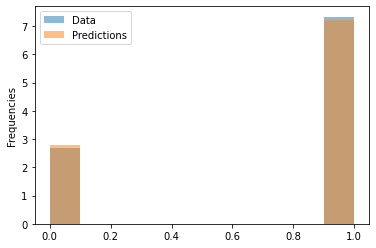

In [8]:
plt.hist(data+new_data, alpha=0.5, density=True)
# I'm flattening the predictions array in order to
# correctly plot the histogram
plt.hist(y_pred_g['y'].flatten(), alpha=0.5, density=True)
plt.legend(['Data','Predictions'])
plt.xlabel('')
plt.ylabel('Frequencies')
plt.show()

If the empirical pmf look alike, we are more confident that the model is correct.

Suppouse that instead of using a Beta(1,1) as our prior, we used a Beta(10,20). Let's see how this affects the posterior predictive checks.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


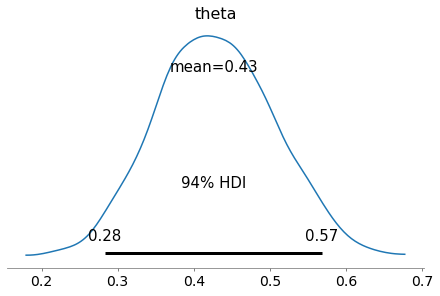

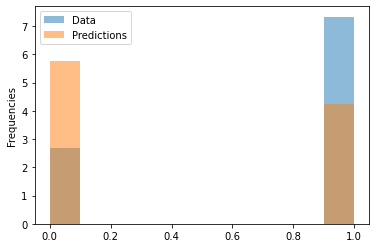

In [60]:
with pm.Model() as model_with_informative_prior:
    # The following line defines the prior, theta distributes as Beta(10,20)
    theta = pm.Beta('theta', alpha=10, beta=20)
    # The following line defines the likelihood Bernoulli with p=theta
    y = pm.Bernoulli('y', p=theta, observed=data)
    # This line generates 1000 samples of the posterior
    trace = pm.sample(1000,  progressbar=True)

    # Plot the sampled posterior
    pp = az.plot_posterior(trace)
    plt.show()

# Here we generate 4000 predictions 
y_pred_g = pm.sample_posterior_predictive(trace, 4000, model_with_informative_prior)

plt.hist(data+new_data, alpha=0.5, density=True)
plt.hist(y_pred_g['y'].flatten(), alpha=0.5, density=True)
plt.legend(['Data','Predictions'])
plt.xlabel('')
plt.ylabel('Frequencies')
plt.show()

In this case, the comparisson on the pmfs indicates that something is not correct with the model. What do you think it is?

## Predictive checks on continuous case

Let's consider the following normal model

$$
\begin{gathered}
        \mu \sim Uniform\left( {40,70} \right) \hfill \\
        \sigma \sim HalfNormal\left( {25} \right) \hfill \\ 
        {y_i}\sim Normal\left( {\mu ,\sigma } \right) \hfill \\
      \end{gathered} $$
     
Here we have two unknown parameters $\mu$ and $\sigma$. The data for this problem is 

In [11]:
data_normal_example = [ 73.3281945 ,  66.14402391,  48.88367929,  48.11718596,
        21.60605466,  57.01679933,  14.65153624,  42.53306488,
        28.69962145,  32.17800945,  53.53189256,  57.00376958,
        52.49968959,  61.00157965,  54.51955565,  69.07906121,
        66.68046798,  52.00062725,  47.92012124,  29.51158737,
        96.66709178,  63.74704325,  23.90101713,  59.23078227,
        65.45805443,  36.29710213,  82.77568656,  56.00869909,
        74.02463031,  50.80696452,  82.76038424,  88.54802732,
        69.67055049,  53.06544853,  43.50715161,  63.40335945,
        61.44197167,  97.17681257,  45.7573031 ,  85.38359329,
        34.54287068,  -2.71882417,  64.18320442, 102.50203421,
        42.39165886,  61.10881835,  66.55962851,  55.36925302,
        56.2455139 ,  34.93306946,  58.48540999,  93.8288581 ,
        69.23431717,  28.11119994,  75.44909436,  51.28620515,
        81.58797242,  55.8973552 ,  55.20545141,  37.26030122,
        59.75908768,  37.87015842,  36.08016894,  46.32094466,
        28.60344779,  16.81770699,  35.26790581,  77.38401879,
        33.53680647, 105.26443755,  57.11857583,  30.86206987,
        63.67911039,  71.68434372,  21.91965421,  26.45693048,
        41.63551317,  27.24299291,  23.83065666,  38.55927058,
        42.80743049,  54.13802634,  47.15271501,  49.96105501,
        37.80659072,  55.86686162,  82.59150895,  33.51299149,
        29.33451615,  68.37844108,  22.04395083,  35.36318439,
        35.01114967,  54.37606878,  48.99032504,  47.16546736,
        37.17186417,  50.99320101,  70.0140447 ,  49.75371196]

With the following code we obtain 1000 samples of the posterior for the parameters $\mu$ and $\sigma$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


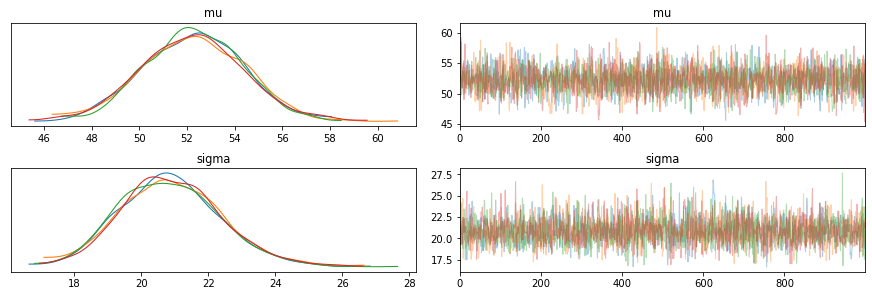

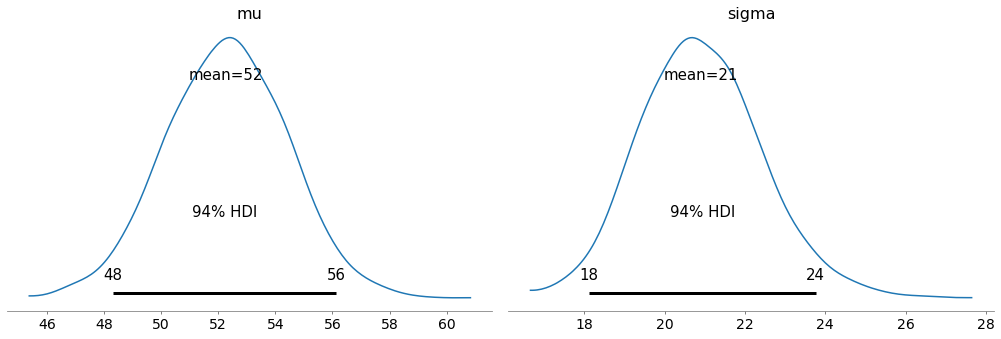

In [17]:
with pm.Model() as normal_model:
    # Prior for the mean     
    mu = pm.Uniform('mu', lower=40, upper=70)
    # Prior for the standard deviation
    sigma = pm.HalfNormal('sigma', sd=25)
    # Likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data_normal_example)
    traces_normal_model = pm.sample(1000)
    az.plot_trace(traces_normal_model)
    az.plot_posterior(traces_normal_model)

As you may have noticed, it a produces row for each parameter. For this model, the posterior is bidimensional, and so the previous figure is showing the marginal distributions of each parameter. We
can use the plot_joint function from ArviZ to see what the bi-dimensional posterior
looks like:

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:xlabel='mu', ylabel='sigma'>

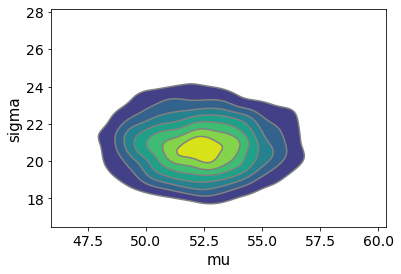

In [13]:
az.plot_pair(traces_normal_model, kind='kde', fill_last=False)

In [18]:
az.summary(traces_normal_model)

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,52.262,2.100,48.309,56.126,0.040,0.028,2798.0,2798.0,2798.0,2331.0,1.0
sigma,20.889,1.509,18.117,23.764,0.027,0.019,3055.0,3004.0,3115.0,2567.0,1.0


Now that we have computed the posterior, we can use it to simulate data and check how
consistent the simulated is data with respect to the observed data.

In [19]:
# Here we generate predictions 
y_pred_normal_model = pm.sample_posterior_predictive(traces_normal_model, model=normal_model)

We can use the plot_ppc function for a visual posterior predictive check

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


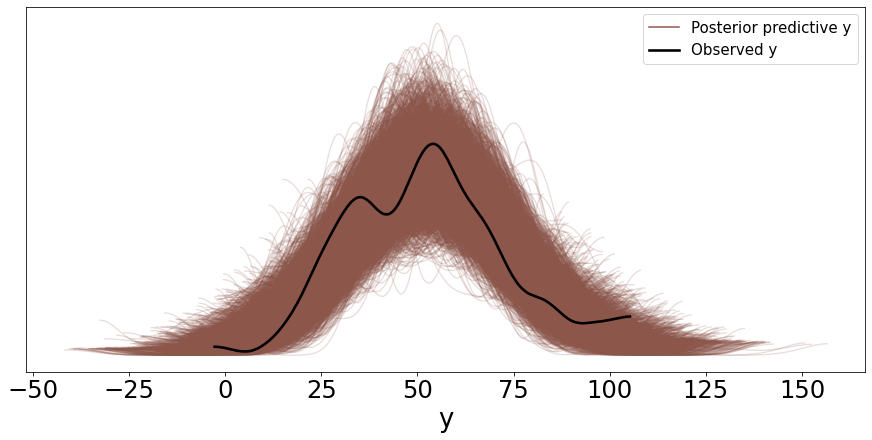

In [21]:
data_ppc = az.from_pymc3(trace=traces_normal_model, posterior_predictive=y_pred_normal_model)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

The single (black) line is a KDE of the data and the many semitransparent
(brown) lines are KDEs computed from each one of the posterior predictive samples. The
semitransparent (brown) lines reflect the uncertainty we have about the inferred distribution
of the predicted data. Sometimes, when you have very few data points. A plot like this one
could show the predicted curves as hairy or wonky; this is due to the way the KDE is
implemented in ArviZ. The density is estimated within the actual range of the data passed
to the kde function, while outside this range the density is assumed to be zero. While some
could reckon this as a bug, I think it's a feature, since it's reflecting a property of the data
instead of over-smoothing it.

Let's suppouse that our data actually comes from an exponential distribution

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


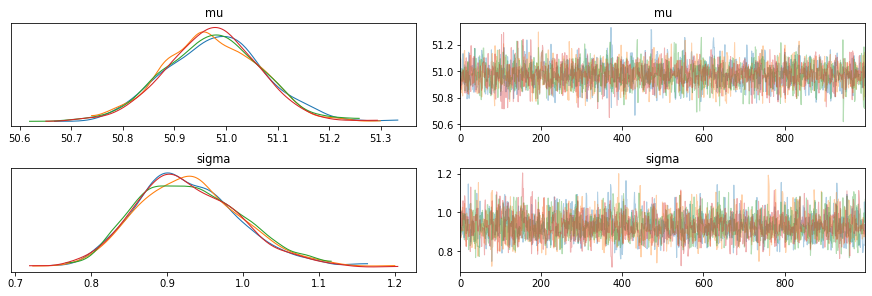

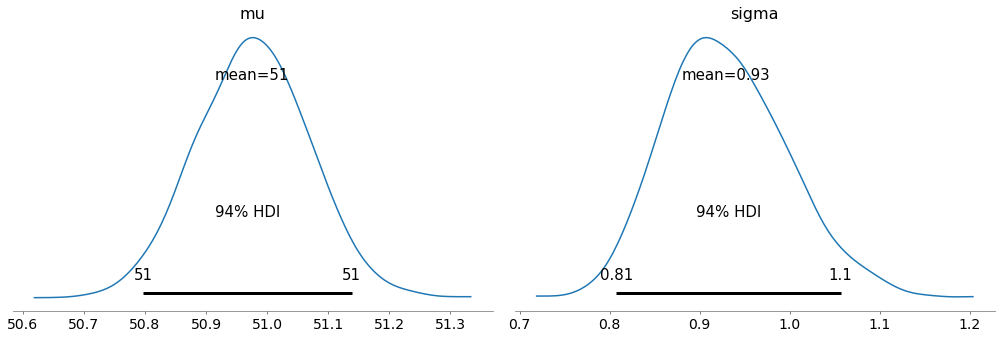

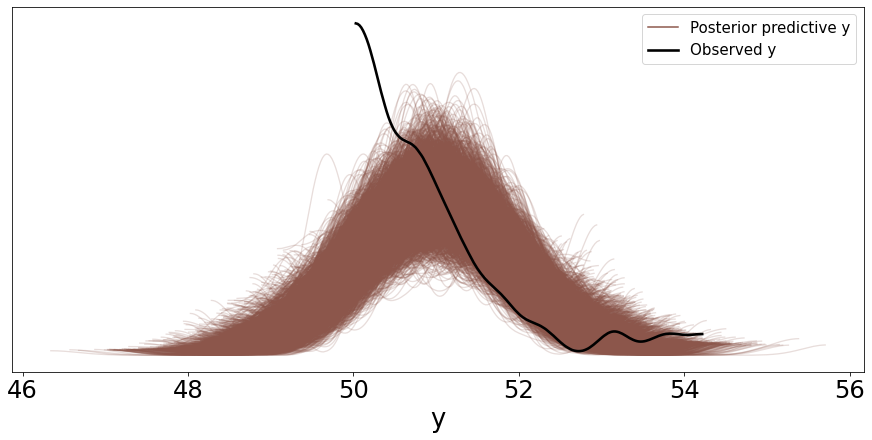

In [22]:
exponential_data = [51.71890417, 51.52989867, 51.19768502, 50.07587698, 50.11895938,
       51.02364632, 50.7204148 , 50.87160323, 50.72192725, 50.59157468,
       51.12538601, 50.57521099, 50.51400783, 51.59580904, 50.29344377,
       50.37283725, 50.09052405, 50.06637147, 50.95769987, 50.43026267,
       51.09102682, 50.61572891, 50.88120627, 50.78542902, 50.40405133,
       50.65738229, 50.05331171, 50.14590964, 50.03565648, 50.16848012,
       54.2168165 , 50.53544686, 51.33870146, 50.30185492, 52.2645269 ,
       53.21577955, 50.09327391, 50.24572219, 52.20798205, 50.24506923,
       50.42217981, 50.89045788, 50.23761075, 50.44328745, 50.31913984,
       52.06044659, 53.06397917, 50.6824757 , 50.40460747, 51.47724307,
       53.62715536, 51.23571322, 51.01264378, 50.36300543, 51.19962718,
       51.4616544 , 51.07307566, 50.76351372, 50.20819704, 50.88091322,
       50.90684445, 51.7856868 , 51.26037191, 50.74145605, 50.76082966,
       50.14072498, 50.21265318, 50.11143837, 53.13399657, 53.90588054,
       50.68867788, 51.87751483, 51.39200431, 50.0870855 , 50.59481925,
       50.72166842, 51.7947655 , 51.64060298, 51.31425169, 50.60241514,
       50.21758119, 50.06812859, 50.73340728, 51.16911463, 50.89974786,
       50.21819167, 50.92764524, 50.3611073 , 52.39966505, 50.31840255,
       53.79727246, 50.30784875, 51.87582813, 50.02905726, 51.08994826,
       51.3367732 , 50.98098735, 50.64939377, 50.29267653, 50.22829566]

with pm.Model() as bad_normal_model:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sd=25)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=exponential_data)
    traces_bad_model = pm.sample(1000)
    az.plot_trace(traces_bad_model)
    az.plot_posterior(traces_bad_model)
    
y_pred_bad_normal_model = pm.sample_posterior_predictive(traces_bad_model, model=bad_normal_model)
data_ppc = az.from_pymc3(trace=traces_bad_model, posterior_predictive=y_pred_bad_normal_model)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

The PPC indicates that there's something wrong with our model. Note that this we would not have noticed it just by looking at the posterior plots.

**NOTE:** If you are only interested in a posterior predictive check, is better not to specify the parameter samples in sample_posterior_predictive.

**NOTE:** The function plot_ppc of Arviz does not work well with discrete data.

# Point estimation

Frequentist point-estimation techniques are typically based on the choice of an intuitively
sensible criteria (e.g., method of moments) and the statistical properties of the resulting
estimators are addressed after the fact. In contrast, Bayesian point estimation begins by
announcing a criterion for determining what constitutes a good point estimate, and a method
for producing an “optimal” point estimate given the data at hand is then derived.

The Bayesian begins by specifying a loss (cost) function $C\left( \widehat \theta, {\theta } \right)$,  that is, a nonnegative
function satisfying $C\left( {\theta ,\theta } \right)=0$, which measures the consequences of using $\widehat \theta  = \widehat \theta \left( Y \right)$ (i.e., a particular function of the data) as an estimate when the “state of nature” is $\theta$. Usually, the loss function is a function of the sampling error $\widehat \theta - \theta$. Frequentists
sometimes argue that the need to specify a loss function is one of the shortcomings of
the Bayesian approach. However, there is usually a frequentist analogue to the Bayesian
choice of loss function. For instance, the familiar concept of mean squared error simply corresponds to a particular type of loss function, namely quadratic loss.

A good estimate is one that “minimizes” $C\left( \widehat \theta, {\theta } \right)$ in some sense, but its randomness must
first be eliminated. From the frequentist sampling theory point of view, $\theta$ is non-stochastic
but $C\left( \widehat \theta, {\theta } \right)$ is nonetheless stochastic because the estimator $\widehat \theta  = \widehat \theta \left( Y \right)$ is a random variable
(i.e., $\widehat \theta$ depends on the random variable $Y$ ). An obvious way to circumscribe the random-
ness of $C\left( \widehat \theta, {\theta } \right)$ is to focus attention on its expected value, assuming it exists. Frequentists
consider the risk function, that is, the nonstochastic function:

$$R\left( {\widehat \theta \left| \theta  \right.} \right) = {E_{Y\left| \theta  \right.}}\left[ {C\left( {\widehat \theta \left( Y \right),\theta } \right)} \right],$$

where the expectation (assumed to exist) is taken with respect to the sampling probability
function $p(y|\theta)$.

In contrast, the Bayesian perspective is entirely ex post (i.e., it conditions on the observed data $y$). That is, the Bayesian uses $\widehat \theta  = \widehat \theta \left( Y \right)$ as a point estimate of the unknown
parameter $\theta$. Unlike the frequentist approach, no role is provided for data that could have
been observed but were not observed. Since $\theta$ is unknown, the Bayesian perspective suggests treating it as a random variable with a distribution reflecting all the information at
hand. Such information is fully contained in the posterior distribution of $\theta$: It reflects both
prior and sample information.

In contrast to the frequentist approach, the randomness in loss function $C\left( \widehat \theta, {\theta } \right)$ from the
Bayesian perspective arises because $\theta$ is an unknown random variable. From the frequentist
perspective, although $\theta$ is unknown, it is treated as a fixed constant. The ex ante perspective
of the frequentist view implies that $C\left( \widehat \theta, {\theta } \right)$ is random because $\widehat \theta$ is viewed as a random
variable with a sampling distribution in repeated samples. The Bayesian solution to the
randomness of the loss function is similar to the frequentist solution: Take its expectation
before minimization. The expectation, however, is with respect to the posterior distribution
$\theta|y$, and not the sampling distribution $y|\theta$ used to obtain the risk function. The Bayesian
prescription is equivalent to the principle usually advocated for economic agents acting in
a world of uncertainty: Using all available information, choose actions so as to maximize
expected utility, or equivalently, minimize expected loss. The prescription is formalized in
the following definition.

Given the posterior density $p(\theta|y)$ and the cost function $C\left( \widehat \theta, {\theta } \right)$, the Bayes
estimate (i.e., the Bayesian point estimate) is defined as the solution (assuming the expectation exists) to the following problem:

$$\mathop {\min }\limits_{\hat \theta } c\left( {\hat \theta } \right) = {E_{\theta \left| y \right.}}\left[ {C\left( {\widehat \theta ,\theta } \right)} \right],$$

where

$${E_{\theta \left| y \right.}}\left[ {C\left( {\widehat \theta ,\theta } \right)} \right] = \int\limits_\Theta  {C\left( {\widehat \theta ,\theta } \right)p\left( {\theta \left| y \right.} \right)d\theta }.$$

## Quadratic loss function

Consider the case of a single parameter of interest $\theta$, let $c$ be a constant. The function 

$$C\left( {\hat \theta ,\theta } \right) = c{\left( {\hat \theta  - \theta } \right)^2}$$

is known as the quadratic loss function.

\begin{align}
{\left( {\hat \theta  - \theta } \right)^2} &= {\left( {\hat \theta  - E\left( {\theta \left| y \right.} \right) + E\left( {\theta \left| y \right.} \right) - \theta } \right)^2}\\
&= {\left( {\hat \theta  - E\left( {\theta \left| y \right.} \right)} \right)^2} + 2\left( {\hat \theta  - E\left( {\theta \left| y \right.} \right)} \right)\left( {E\left( {\theta \left| y \right.} \right) - \theta } \right) + {\left( {E\left( {\theta \left| y \right.} \right) - \theta } \right)^2}
\end{align}

Note that only the last two terms involve $\theta$. Then,

\begin{align}
{E_{\theta \left| y \right.}}\left[ {c{{\left( {\hat \theta  - \theta } \right)}^2}} \right] &= c\left( {{{\left( {\hat \theta  - E\left( {\theta \left| y \right.} \right)} \right)}^2} + 2\left( {\hat \theta  - E\left( {\theta \left| y \right.} \right)} \right){E_{\theta \left| y \right.}}\left( {E\left( {\theta \left| y \right.} \right) - \theta } \right) + {E_{\theta \left| y \right.}}{{\left( {E\left( {\theta \left| y \right.} \right) - \theta } \right)}^2}} \right)\\
& = c{\left( {\hat \theta  - E\left( {\theta \left| y \right.} \right)} \right)^2} + 0 + cVar\left( {\theta |y} \right).
\end{align}

which is minimized by setting the first term to zero. This means that, the bayesian estimation of $\theta$ that minimizes the quadratic loss is the expected value, i.e. $\widehat \theta={E\left( {\theta \left| y \right.} \right)}$.

In a practical problem, to calculate this, we just need to sample several samples of the posterior and take the average.

## MAP (Maximum a posteriori)

Another popular bayesian point estimation method is the MAP Maximum a posteriori). Its formulation is quite simple and intuitive: given the value of the observations $y$, $\theta_{MAP}$ is the value of $\theta$ that maximizes the posterior distribution.

<img src="https://parisnanterrefr.sharepoint.com/sites/StatistiqueetanalyseBaysienne/Supports%20de%20cours/map.PNG" width="500" height="500" />

The form of the posterior distribution, as given by Bayes' rule, allows
an important computational shortcut: the denominator is the same for all $\theta$
and depends only on the value $y$ of the observation. Thus, to maximize the
posterior, we only need to choose a value of $\theta$ that maximizes the numerator (likelihood $\times$ prior). Calculation of the denominator is unnecessary.

Let's calculate the MAP estimator on the coin tossing example: the likelihood is $Binomial(n,\theta)$ and the prior is uniform in 0,1. Let $n$ be the number of trials and $k$ the number of successes. By Bayes' formula

$$p\left( {\theta \left| y \right.} \right) \propto \left( \begin{gathered}
  n \hfill \\
  k \hfill \\ 
\end{gathered}  \right){\theta ^k}{\left( {1 - \theta } \right)^{n - k}}{I_{\left[ {0,1} \right]}}\left( \theta  \right),$$

Note that the combinatorial number $\left( \begin{gathered}
  n \hfill \\
  k \hfill \\ 
\end{gathered}  \right)$ does not depend on $\theta$, so we just need to find the maximum of ${\theta ^k}{\left( {1 - \theta } \right)^{n - k}}{I_{\left[ {0,1} \right]}}\left( \theta  \right)$. Because this function is 0 outside the interval $[0,1]$, our problem reduces to finding the maximum of the function $h(\theta)={\theta ^k}{\left( {1 - \theta } \right)^{n - k}}$ over the interval $[0,1]$. Taking derivatives with respect to $\theta$

$$h^\prime \left( \theta  \right) = k{\theta ^{k - 1}}{\left( {1 - \theta } \right)^{n - k}} - \left( {n - k} \right){\theta ^k}{\left( {1 - \theta } \right)^{n - k - 1}},$$

putting this equal 0, we obtain that the maximum is attained at $\frac{k}{n}$, therefore, $\widehat\theta_{MAP}=\frac{k}{n}$. Note that in this case, MAP estimation coincides with the most likelihood estimation.

PyMC3 provides the function `find_MAP` to calculate the MAP.

The ussage is as follows

In [23]:
# Sample data
data = [1, 1, 1, 0, 1, 1, 0, 0, 1, 1]

with pm.Model() as coin_flipping_model:
    # The following line defines the prior, theta distributes as Beta(1,1)
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # The following line defines the likelihood Bernoulli with p=theta
    y = pm.Bernoulli('y', p=theta, observed=data)
    map_estimator = pm.find_MAP()
    print("The MAP estimator for the model is {0}".format(map_estimator['theta']))


The MAP estimator for the model is 0.7000004628169669


Let's plot the posterior distribution to check that the MAP function works correctly

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.6912833772169941, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


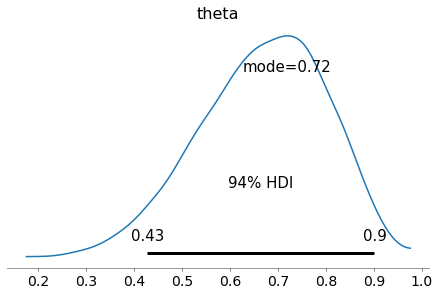

In [24]:
trace = pm.sample(4000, progressbar=True, model=coin_flipping_model)
# Plotting the posterior, and showing the mode instead of the mean
pp = az.plot_posterior(trace, point_estimate='mode')
plt.show()

# Misc

PyMC3 can create directed acyclic graphs (DAGs) from models that are very similar to Kruschke's diagrams. You can obtain them using the `pm.model_to_graphviz` function

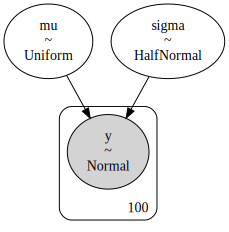

In [72]:
pm.model_to_graphviz(model=normal_model)

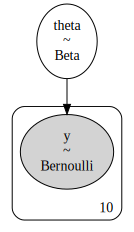

In [73]:
pm.model_to_graphviz(model=coin_flipping_model)

To create this diagrams, you need to install the package graphviz, to do this, 

`conda activate bayesianStats`

`conda install -c conda-forge python-graphviz`